# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST

As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains
images of handwritten digits. You can view the first number of examples by
changing `show_n_images`.

In [2]:
# !sudo pip3 install -U matplotlib==2.0.2

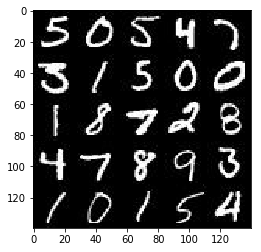

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(
    glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA

The [CelebFaces Attributes Dataset
(CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains
over 200,000 celebrity images with annotations. Since you're going to be
generating faces, you won't need the annotations. You can view the first number
of examples by changing `show_n_images`.

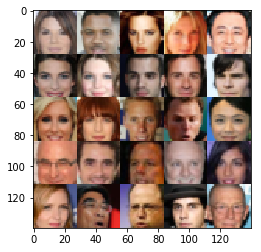

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(
    glob(os.path.join(
        data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data

Since the project's main focus is on building the GANs, we'll preprocess the
data for you. The values of the MNIST and CelebA dataset will be in the range of
-0.5 to 0.5 of 28x28 dimensional images. The CelebA images will be cropped to
remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color
channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the
CelebA images have [3 color channels (RGB color
channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network

You'll build the components necessary to build a GANs by implementing the
following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU

This will check to make sure you have the correct version of TensorFlow and
access to a GPU

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

### Input

Implement the `model_inputs` function to create TF Placeholders for the Neural
Network. It should create the following placeholders:

- Real input images placeholder with rank 4 using `image_width`, `image_height`,
  and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images,
tensor of z data)

In [22]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image_placeholder = tf.placeholder(
        shape=(None, image_width, image_height, image_channels), dtype=tf.float32)
    z_placholder = tf.placeholder(shape=(None, z_dim), dtype=tf.float32)
    learning_rate = tf.placeholder(dtype=tf.float32)
    return image_placeholder, z_placholder, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

Implement `discriminator` to create a discriminator neural network that
discriminates on `images`. This function should be able to reuse the variables
in the neural network. Use
[`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope)
with a scope name of "discriminator" to allow the variables to be reused. The
function should return a tuple of (tensor output of the discriminator, tensor
logits of the discriminator).

In [46]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)        
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x3 = tf.layers.conv2d(relu3, 512, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)        
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x3 = tf.layers.conv2d(relu3, 1024, 2, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)        
        relu3 = tf.maximum(alpha * bn3, bn3)
    
        # Flatten it
        flat = tf.keras.layers.Flatten()(relu3)
        hidden = tf.layers.dense(flat, 128)
        hidden = tf.maximum(alpha*hidden, hidden)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator

Implement `generator` to generate an image using `z`. This function should be
able to reuse the variables in the neural network. Use
[`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope)
with a scope name of "generator" to allow the variables to be reused. The
function should return the generated 28 x 28 x `out_channel_dim` images.

In [47]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(x1, 512, kernel_size=4, strides=1)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x3 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
        return out
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [48]:
def model_loss(input_real, input_z, output_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, output_dim)
    d_model_real, d_logits_real = discriminator(2*input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [49]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [50]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [51]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    model_input_args = data_shape[1:] + (z_dim, )
    input_real, input_z, input_learning_rate = model_inputs(*model_input_args)
    output_chanel_dim = 3 if data_image_mode == 'RGB' else 1
    d_loss, g_loss = model_loss(input_real, input_z, output_chanel_dim)

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                # batch_images = 2*batch_images
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 40 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 200 == 0:
                    show_generator_output(sess, 24, input_z, output_chanel_dim,
                                          data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')
        show_generator_output(sess, 24, input_z, output_chanel_dim, data_image_mode)

    # with open('samples.pkl', 'wb') as f:
    #     pkl.dump(samples, f)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0562... Generator Loss: 10.4223
Epoch 1/2... Discriminator Loss: 0.3620... Generator Loss: 12.1306
Epoch 1/2... Discriminator Loss: 0.4467... Generator Loss: 1.4479
Epoch 1/2... Discriminator Loss: 0.3574... Generator Loss: 1.9166
Epoch 1/2... Discriminator Loss: 0.8122... Generator Loss: 1.6867


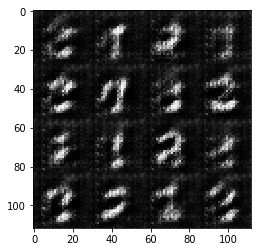

Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 2.5407
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 0.8573
Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 1.3538
Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 0.6134... Generator Loss: 1.6832


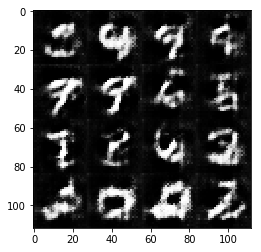

Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.4316
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 1.5145
Epoch 1/2... Discriminator Loss: 1.0050... Generator Loss: 0.8343
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.6081
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 2.4506


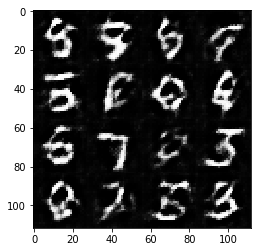

Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 2.1614
Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 0.3322
Epoch 1/2... Discriminator Loss: 0.9345... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 0.7087


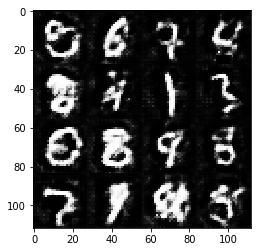

Epoch 1/2... Discriminator Loss: 2.3573... Generator Loss: 0.1366
Epoch 1/2... Discriminator Loss: 0.3469... Generator Loss: 1.6525
Epoch 1/2... Discriminator Loss: 0.7621... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 0.9794
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.4567


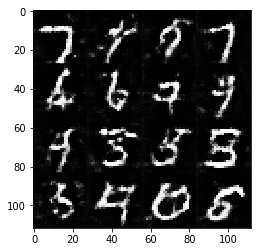

Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 0.5481
Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 0.6853
Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 0.5576
Epoch 1/2... Discriminator Loss: 0.5695... Generator Loss: 2.2360
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 1.2286


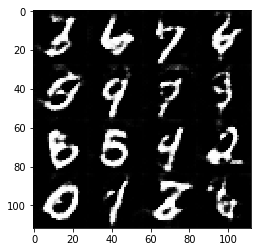

Epoch 1/2... Discriminator Loss: 1.5295... Generator Loss: 0.2818
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 0.3171


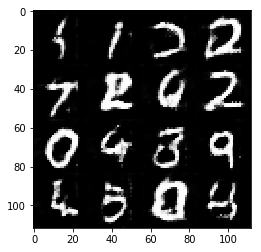

Epoch 1/2... Discriminator Loss: 0.6041... Generator Loss: 1.4626
Epoch 1/2... Discriminator Loss: 0.4308... Generator Loss: 2.3301
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 0.6399
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 0.2933
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.3839


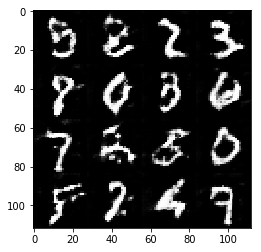

Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 1.7005... Generator Loss: 0.2312
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 1.6287
Epoch 1/2... Discriminator Loss: 1.9698... Generator Loss: 0.1839


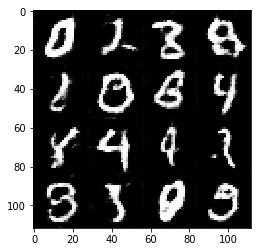

Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.3963
Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 1.2655
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.3767
Epoch 2/2... Discriminator Loss: 2.5752... Generator Loss: 0.0873
Epoch 2/2... Discriminator Loss: 2.5309... Generator Loss: 0.1017


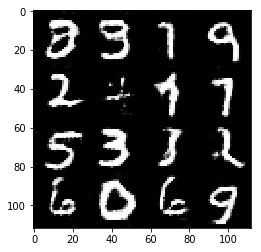

Epoch 2/2... Discriminator Loss: 2.3490... Generator Loss: 0.1184
Epoch 2/2... Discriminator Loss: 0.3235... Generator Loss: 1.3653
Epoch 2/2... Discriminator Loss: 1.6157... Generator Loss: 0.2577
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.5181
Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 0.8817


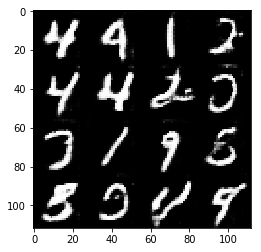

Epoch 2/2... Discriminator Loss: 1.7128... Generator Loss: 0.2341
Epoch 2/2... Discriminator Loss: 0.4977... Generator Loss: 1.1451
Epoch 2/2... Discriminator Loss: 1.7696... Generator Loss: 0.2119
Epoch 2/2... Discriminator Loss: 0.3284... Generator Loss: 1.8958
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.3650


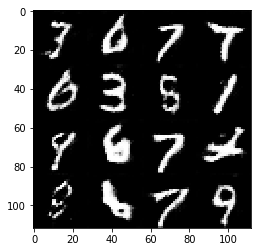

Epoch 2/2... Discriminator Loss: 2.2478... Generator Loss: 0.1281
Epoch 2/2... Discriminator Loss: 0.3636... Generator Loss: 1.3223
Epoch 2/2... Discriminator Loss: 1.1570... Generator Loss: 0.4211
Epoch 2/2... Discriminator Loss: 0.0485... Generator Loss: 3.5320
Epoch 2/2... Discriminator Loss: 0.4852... Generator Loss: 1.0841


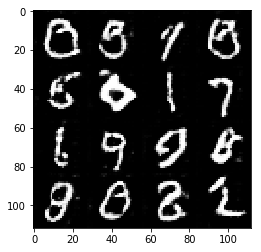

Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.4291
Epoch 2/2... Discriminator Loss: 0.1560... Generator Loss: 2.2947
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 0.9056
Epoch 2/2... Discriminator Loss: 0.4753... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 0.8391


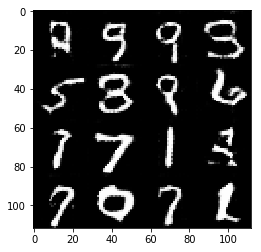

Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 1.4700
Epoch 2/2... Discriminator Loss: 1.0688... Generator Loss: 0.4942
Epoch 2/2... Discriminator Loss: 0.5472... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.5746... Generator Loss: 0.2494
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 0.5316


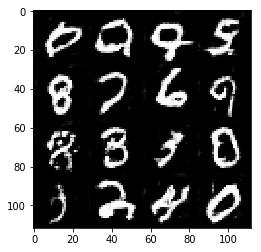

Epoch 2/2... Discriminator Loss: 1.9756... Generator Loss: 0.1989
Epoch 2/2... Discriminator Loss: 0.2733... Generator Loss: 1.5968
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.4493
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 0.5876
Epoch 2/2... Discriminator Loss: 0.2057... Generator Loss: 1.8266


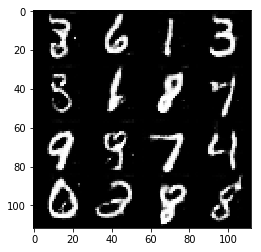

Epoch 2/2... Discriminator Loss: 1.7024... Generator Loss: 0.2245
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 0.4469
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 1.0002... Generator Loss: 0.5311
Epoch 2/2... Discriminator Loss: 1.4785... Generator Loss: 0.2845


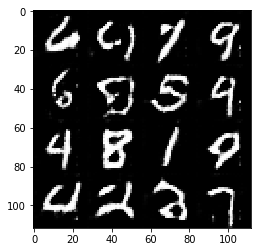

Epoch 2/2... Discriminator Loss: 0.3597... Generator Loss: 3.2569
Epoch 2/2... Discriminator Loss: 0.2476... Generator Loss: 2.2225
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 0.4828
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 2.7738
Epoch 2/2... Discriminator Loss: 0.6649... Generator Loss: 0.8911


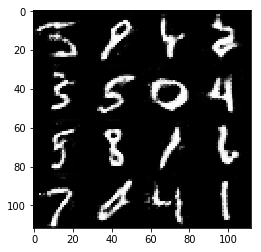

Epoch 2/2... Discriminator Loss: 2.8638... Generator Loss: 0.0688
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 0.6625
Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 0.6621


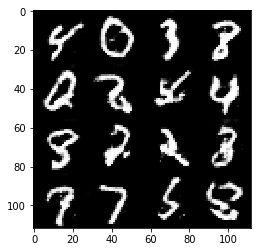

In [52]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.keras.backend.set_learning_phase(1)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1280... Generator Loss: 4.7947
Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 8.1664
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.4112
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 2.8579
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.1445


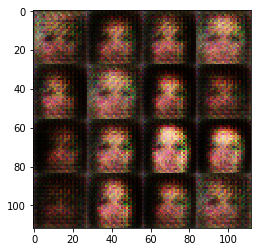

Epoch 1/1... Discriminator Loss: 2.3178... Generator Loss: 0.1538
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.4781
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.4205
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.7063
Epoch 1/1... Discriminator Loss: 1.7422... Generator Loss: 0.2558


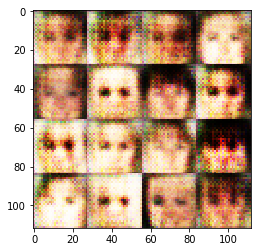

Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 2.0406
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 1.0680


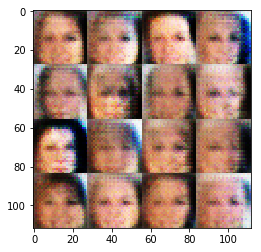

Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.1264


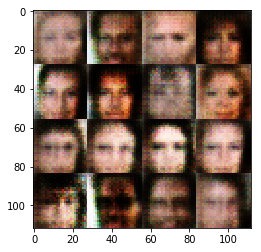

Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.3304
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 0.8840


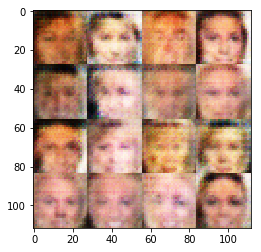

Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 1.5659
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.3039


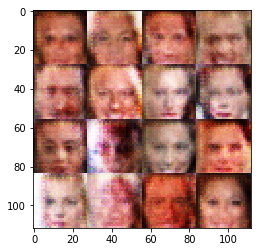

Epoch 1/1... Discriminator Loss: 2.0250... Generator Loss: 0.1811
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.7095


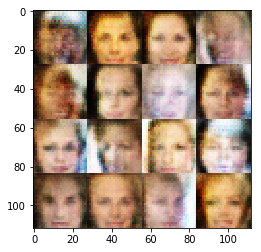

Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 0.8261


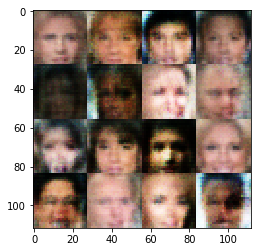

Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.0271


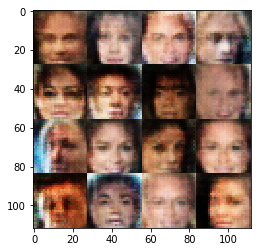

Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.4251
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 0.7463


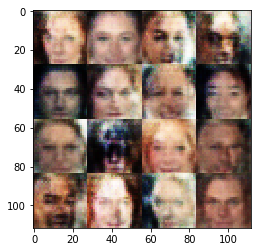

Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.6512
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.5730


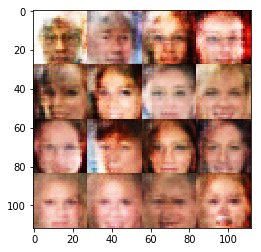

Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.4399


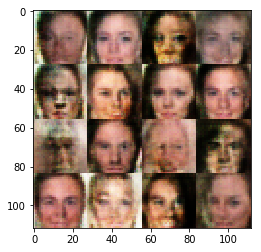

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.2698
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.3418


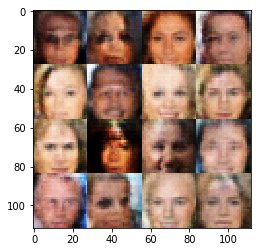

Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 2.2973


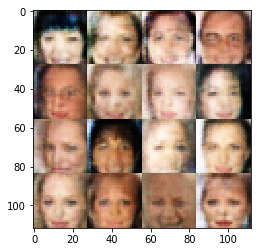

Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.7255


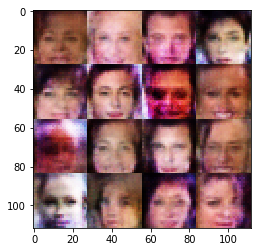

Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.2986
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.4702


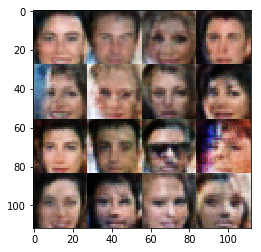

Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.3756
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.7174


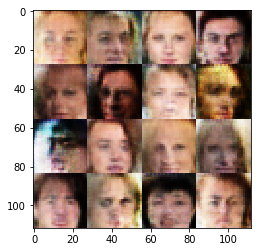

Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.3230
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.3945
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.5710


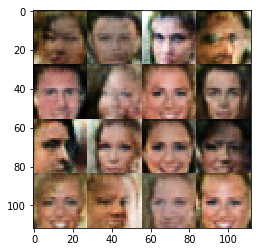

Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.2957
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 1.1872


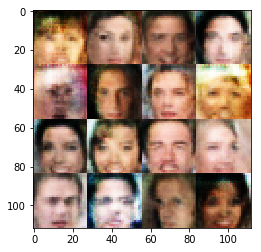

Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.2412


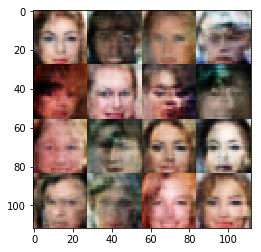

Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.3153
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.3724


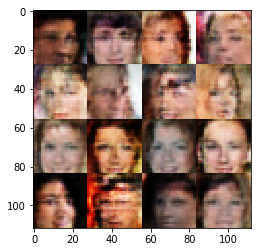

Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.5548
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 0.9586


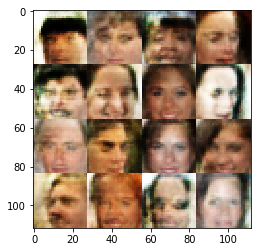

Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.5264
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 0.7677


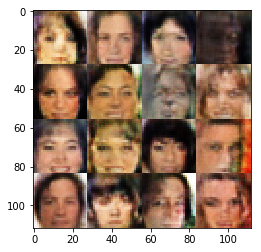

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.3782
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.3898
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.0013


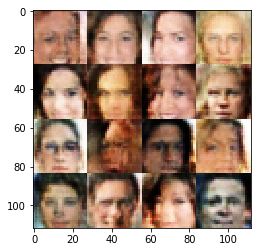

Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.3291
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 0.7735


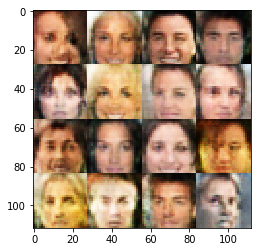

Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.3380
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 0.8199


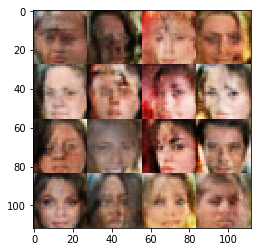

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.3304
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 0.7518


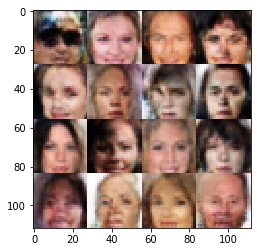

Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 2.1015... Generator Loss: 0.1510
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.3711
Epoch 1/1... Discriminator Loss: 1.7861... Generator Loss: 0.2275
Epoch 1/1... Discriminator Loss: 1.8723... Generator Loss: 1.7262


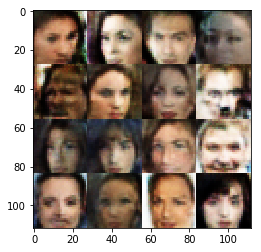

Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 2.0162... Generator Loss: 0.1963


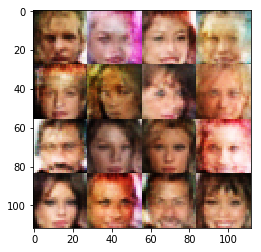

Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.2779
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.3011
Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 0.6885


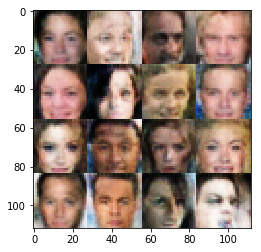

Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.7764
Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 0.2577
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.6478


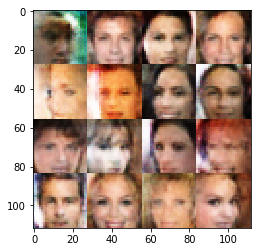

Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.5089


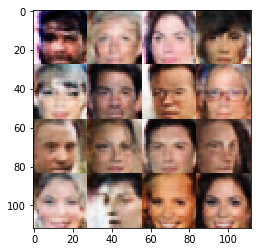

In [53]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.